## Importing Relevant Libraries

In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
# %matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

In [2]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Analysis

*   there are 7613 data points.
*   **99.198739%** of the data has **keywords**.
*   **66.73%** of the data has **location** points
*   the top key word used to extract tweets is **fatalities**.
*   data is ordered in terms of keyword used to extact the tweet from twitter.

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
*   keyword and location features were dropped as they add no significant value to the model performance.


### Data Cleaning

In [3]:
data_after_null_removal = data.copy()
#data_after_null_removal = data_after_null_removal.dropna(subset=['location'])
# Removing duplicates
data_after_duplicate_removal = data_after_null_removal.drop_duplicates(subset=['text'])

nltk.download('stopwords')
#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_duplicate_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnews fallen powerlines glink tram update fire crews evacuated passengers tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyone evacuate stay tuned blow,1
7606,10866,NaN,NaN,suicide bomber kills saudi security site mosque reuters via world google news wall,1
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearby homes,1


In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')

porter =  PorterStemmer()

def sentenceStemmer(text):
	words = word_tokenize(text)
	corpus = []
	for word in words:
		corpus.append(porter.stem(word))
		corpus.append(" ")
	#end for
	return "".join(corpus)
#end sentenceStemmer
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: sentenceStemmer(x))
data_without_tockenization

[nltk_data] Downloading package punkt to /home/patrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu shelter place order expect,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,NaN,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1


In [5]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[6])
print(X_train[6])

crash car park car day modestmouseremix truestori 
[19, 53, 601, 53, 31, 4833, 4834]


### Model

In [40]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras import layers

embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           627250    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 627,771
Trainable params: 627,771
Non-trainable params: 0
_________________________________________________________________


In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [42]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_model = model.to_json()
with open('./NN_Models/keras_embed_mlp_model.json', 'w') as json_file:
    json_file.write(keras_embed_model)

model.save_weights('./NN_Models/keras_embed_mlp_model.h5')

print('saved model!')

Epoch 1/50
676/676 [==============================] - 9s 13ms/step - loss: 0.5716 - accuracy: 0.7019 - precision: 0.8136 - recall: 0.3899 - val_loss: 0.4885 - val_accuracy: 0.7683 - val_precision: 0.7744 - val_recall: 0.6438
Epoch 2/50
676/676 [==============================] - 7s 11ms/step - loss: 0.3434 - accuracy: 0.8568 - precision: 0.8640 - recall: 0.7880 - val_loss: 0.5126 - val_accuracy: 0.7710 - val_precision: 0.7782 - val_recall: 0.6469
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


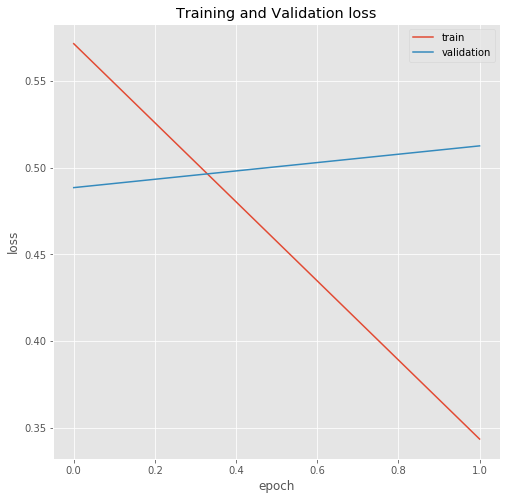

In [43]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [44]:
model.evaluate(X_train, y_train, verbose=False)

[0.22483226656913757,
 0.9191350936889648,
 0.9491525292396545,
 0.8561500906944275]

### Testing Model

In [45]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,372,59
Positive,113,207


In [46]:
results

,Value
Accuracy,0.770972
Precision,0.778195
FPR,0.136891
Recall,0.646875
F1,0.706485


### Summary of Keras Embedding Layer
- The highest achievable accuracy is 77%.
- F1 score is 0.7.
- Recall and Precision are 65% and 77% respectively.
- Validation loss never goes below ~0.34.
- Best performance is at batch size of 32.
- The base model seems to be better than this in terms of accuracy.

# SimpleRNN+keras embedding layer

In [60]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [61]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [89]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,SpatialDropout1D

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 50)           627250    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 50)           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 100, 128)          22912     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 662,579
Trainable params: 662,579
Non-trainable params: 0
_______________________________________________

In [90]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

keras_embed_RNN_model = model.to_json()
with open('./NN_Models/keras_embed_RNN_model.json', 'w') as json_file:
    json_file.write(keras_embed_RNN_model)

model.save_weights('./NN_Models/keras_embed_RNN_model.h5')

print('saved model!')

Epoch 1/30
190/190 [==============================] - 5s 25ms/step - loss: 0.5850 - accuracy: 0.6944 - val_loss: 0.5201 - val_accuracy: 0.7544
Epoch 2/30
190/190 [==============================] - 5s 24ms/step - loss: 0.3869 - accuracy: 0.8341 - val_loss: 0.5307 - val_accuracy: 0.7737
Epoch 3/30
190/190 [==============================] - 5s 25ms/step - loss: 0.2657 - accuracy: 0.8986 - val_loss: 0.5419 - val_accuracy: 0.7574
Epoch 4/30
190/190 [==============================] - 5s 26ms/step - loss: 0.1911 - accuracy: 0.9297 - val_loss: 0.6672 - val_accuracy: 0.7633
Epoch 5/30
190/190 [==============================] - 4s 24ms/step - loss: 0.1466 - accuracy: 0.9460 - val_loss: 0.7142 - val_accuracy: 0.7515
Epoch 6/30
190/190 [==============================] - 5s 25ms/step - loss: 0.1228 - accuracy: 0.9580 - val_loss: 0.7834 - val_accuracy: 0.7293
Epoch 7/30
190/190 [==============================] - 5s 28ms/step - loss: 0.1004 - accuracy: 0.9641 - val_loss: 0.8945 - val_accuracy: 0.7367

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


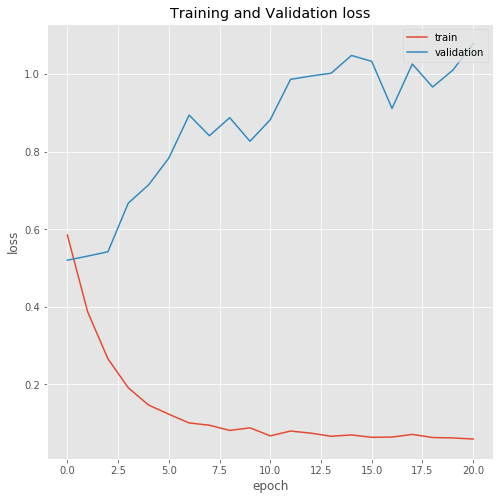

In [91]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [92]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,336,95
Positive,120,200


In [88]:
results

,Value
Accuracy,0.693742
Precision,0.652027
FPR,0.238979
Recall,0.603125
F1,0.626623


# LSTM+keras embedding layer

In [77]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [78]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [94]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D, Bidirectional

embedding_dim = 64
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
#model.add(SpatialDropout1D(0.25))
#model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 64)           802880    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 835,969
Trainable params: 835,969
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=64,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

lstm_keras_embed_model = model.to_json()
with open('./NN_Models/lstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(lstm_keras_embed_model)

model.save_weights('./NN_Models/lstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/50
95/95 [==============================] - 4s 37ms/step - loss: 0.5782 - accuracy: 0.6820 - val_loss: 0.4649 - val_accuracy: 0.7899
Epoch 2/50
95/95 [==============================] - 3s 31ms/step - loss: 0.3528 - accuracy: 0.8639 - val_loss: 0.4590 - val_accuracy: 0.7959
Epoch 3/50
95/95 [==============================] - 3s 32ms/step - loss: 0.2750 - accuracy: 0.9001 - val_loss: 0.5321 - val_accuracy: 0.7870
Epoch 4/50
95/95 [==============================] - 3s 32ms/step - loss: 0.2217 - accuracy: 0.9230 - val_loss: 0.6331 - val_accuracy: 0.7648
Epoch 5/50
95/95 [==============================] - 3s 31ms/step - loss: 0.1895 - accuracy: 0.9376 - val_loss: 0.6330 - val_accuracy: 0.7840
Epoch 00005: early stopping
saved model!


In [81]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,361,70
Positive,115,205


In [82]:
results

,Value
Accuracy,0.753662
Precision,0.745455
FPR,0.162413
Recall,0.640625
F1,0.689076


# Bidirectional+keras embedding layer

In [95]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          1254500   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 1,653,477
Trainable params: 1,653,477
Non-trainable params: 0
___________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

blstm_keras_embed_model = model.to_json()
with open('./NN_Models/blstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(blstm_keras_embed_model)

model.save_weights('./NN_Models/blstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/50
190/190 [==============================] - 22s 118ms/step - loss: 0.5331 - accuracy: 0.7354 - val_loss: 0.4564 - val_accuracy: 0.7973
Epoch 2/50
190/190 [==============================] - 20s 105ms/step - loss: 0.3418 - accuracy: 0.8645 - val_loss: 0.4777 - val_accuracy: 0.7811
Epoch 3/50
 27/190 [===>..........................] - ETA: 15s - loss: 0.2392 - accuracy: 0.9109

In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

In [ ]:
results